In [191]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import scipy
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
import tools
from tools.FV3_tools import read_solo_fields, read_solo_w
from tools.CM1_tools import read_cm1_fields, read_cm1_w

from pltbook import nice_clevels, nice_mxmnintvl, container, plot_contour_row
from tools.CM1_tools import read_cm1_fields, read_cm1_w
from tools.FV3_tools import read_solo_fields, read_solo_w

import matplotlib.colors as mcolors

cmap_data = [(1.0,                1.0,                 1.0),
             (0.3137255012989044, 0.8156862854957581,  0.8156862854957581),
             (0.0,                1.0,                 1.0),
             (0.0,                0.8784313797950745,  0.501960813999176),
             (0.0,                0.7529411911964417,  0.0),
             (0.501960813999176,  0.8784313797950745,  0.0),
             (1.0,                1.0,                 0.0),
             (1.0,                0.6274510025978088,  0.0),
             (1.0,                0.0,                 0.0),
             (1.0,                0.125490203499794,   0.501960813999176),
             (0.9411764740943909, 0.250980406999588,   1.0),
             (0.501960813999176,  0.125490203499794,   1.0),
             (0.250980406999588,  0.250980406999588,   1.0),
             (0.125490203499794,  0.125490203499794,   0.501960813999176),
             (0.125490203499794,  0.125490203499794,   0.125490203499794),
             (0.501960813999176,  0.501960813999176,   0.501960813999176),
             (0.8784313797950745, 0.8784313797950745,  0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872,  0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525,  0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]

linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
]

_nthreads = 2

# draw filled contours

wclevs  = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 60, 70, 80]

scaled_wclevs = list(0.05 + 0.05*np.arange(26))

tclevs  = list(-40.0 + 2*np.arange(41))

pclevs  = list(-15.0 + np.arange(31))

dclevs  = list(-20.0 + np.arange(41))

zlevels = 25.0 + 60.*np.arange(300)

raw_cape = {"QV12": [915., 1430., 978.],
            "QV13": [1364.4, 1904., 1437.0],
            "QV14": [1872.2, 2354.1, 1953.3],
            "QV15": [2427.5, 2800.2, 2514.6], 
            "QV16": [ 3007.0, 3289.6,  3096.1] }

plotlabels = ["QV12", "QV14", "QV16"]

cape_mean = []

def geomean(cape):
    return (cape[0] * cape[1] * cape[2])**(1./3.)

for key in raw_cape:
    cape_mean.append(geomean(raw_cape[key]))

w_ideal = np.sqrt(2.0*np.array(cape_mean))

print(w_ideal)
print(cape_mean)
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[46.59768368 55.70051812 64.02349047 71.77687254 79.10372129]
[1085.672061987397, 1551.273859658991, 2049.503665750544, 2575.9597158272036, 3128.6993610705954]


In [145]:
def plot_wmax(cmodel, smodel, res=3, subtitle='CM1 and FV3-SOLO'):
    
    fig, ax = plt.subplots(1,2, figsize=(16,8))

    linestyles = [':','--','solid'] 
    
    capes = [1085.672061987397, 2049.503665750544, 3128.6993610705954]

    wscale = [46.59768368, 64.02349047, 79.10372129]

    for n, item in enumerate(cmodel):
        # if n == 0:
        #     linestyle = 'solid'
        # else:
        #     linestyle = linestyle_tuple[n][1:][0]
            
        ax[0].plot(item.sec/60, item.w.max(axis=(1,2,3)), label=f"CM1-{int(capes[n])}", linestyle=linestyles[n], color='k')
        
    for n, item in enumerate(smodel):
        # if n == 0:
        #     linestyle = 'solid'
        # else:
        #     linestyle = linestyle_tuple[n][1:][0]
            
        ax[0].plot(item.sec/60, item.w.max(axis=(1,2,3)), label=f"FV3-{int(capes[n])}", linestyle=linestyles[n], color='r')
    
    ax[0].set_xlim(0,60.)
    ax[0].set_title(f'DX = {res} KM: W Time Series for {subtitle}')
    ax[0].legend()
    ax[0].set_xlabel('Time (sec)')
    ax[0].set_ylabel('W (m/s)')
    ax[0].axvline(x=19., color='k', linestyle='solid', alpha=0.4)
    
    for n, item in enumerate(cmodel):
        if n == 0:
            linestyle = 'solid'
        else:
            linestyle = linestyle_tuple[n][1:][0]
            
        ax[1].plot(item.sec/60, item.w.max(axis=(1,2,3))/wscale[n], label=f"CM1-{int(capes[n])}", linestyle=linestyles[n], color='k')
        
    for n, item in enumerate(smodel):
        if n == 0:
            linestyle = 'solid'
        else:
            linestyle = linestyle_tuple[n][1:][0]
            
        ax[1].plot(item.sec/60, item.w.max(axis=(1,2,3))/wscale[n], label=f"FV3-{int(capes[n])}", linestyle=linestyles[n], color='r')
    
    ax[1].set_xlim(0,60)
    ax[1].set_ylim(0,1.2)
    ax[1].axhline(y=0.9995, color='k', linestyle='solid', alpha=0.4)
    ax[1].axvline(x=19., color='k', linestyle='solid', alpha=0.4)
    ax[1].set_title(f'DX = {res} KM: Scaled W Time Series for {subtitle}')
    ax[1].set_xlabel('Time (sec)')
    ax[1].legend()
    ax[1].set_ylabel('Fraction of Max W from Cape');

# **3 km plots**

In [185]:
euler  = '/work/wicker/climate_runs/FV3_Solo/bubble/euler/3km'
div    = '/work/wicker/climate_runs/FV3_Solo/bubble/euler/3km_old'
cm1    = '/work/wicker/climate_runs/cm1r20.3/run/bubble/3km'
rk2    = '/work/wicker/climate_runs/FV3_Solo/bubble/rk2/3km'

s3 = []
c3 = []
d3 = []
rk = []

for key in plotlabels:  
    s3.append(read_solo_w(os.path.join(euler_3km,key)))
    d3.append(read_solo_w(os.path.join(div,key)))
    rk.append(read_solo_w(os.path.join(rk2,key)))
    c3.append(read_cm1_w(os.path.join(cm1_3km,key)))
 

------------------------------------------------------------------------------------------------------------------------
 Now Reading:  /work/wicker/climate_runs/FV3_Solo/bubble/euler/3km/QV12/atmos_hifreq.nc
 Completed reading: /work/wicker/climate_runs/FV3_Solo/bubble/euler/3km/QV12/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
 Now Reading:  /work/wicker/climate_runs/FV3_Solo/bubble/div/3km/QV12/atmos_hifreq.nc
 Completed reading: /work/wicker/climate_runs/FV3_Solo/bubble/div/3km/QV12/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
 Now Reading:  /work/wicker/climate_runs/FV3_Solo/bubble/rk2/3km/QV12/atmos_hifreq.nc
 Completed reading: /work/wicker/climate_runs/FV3_Solo/bubble/rk2/3km/QV12/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------

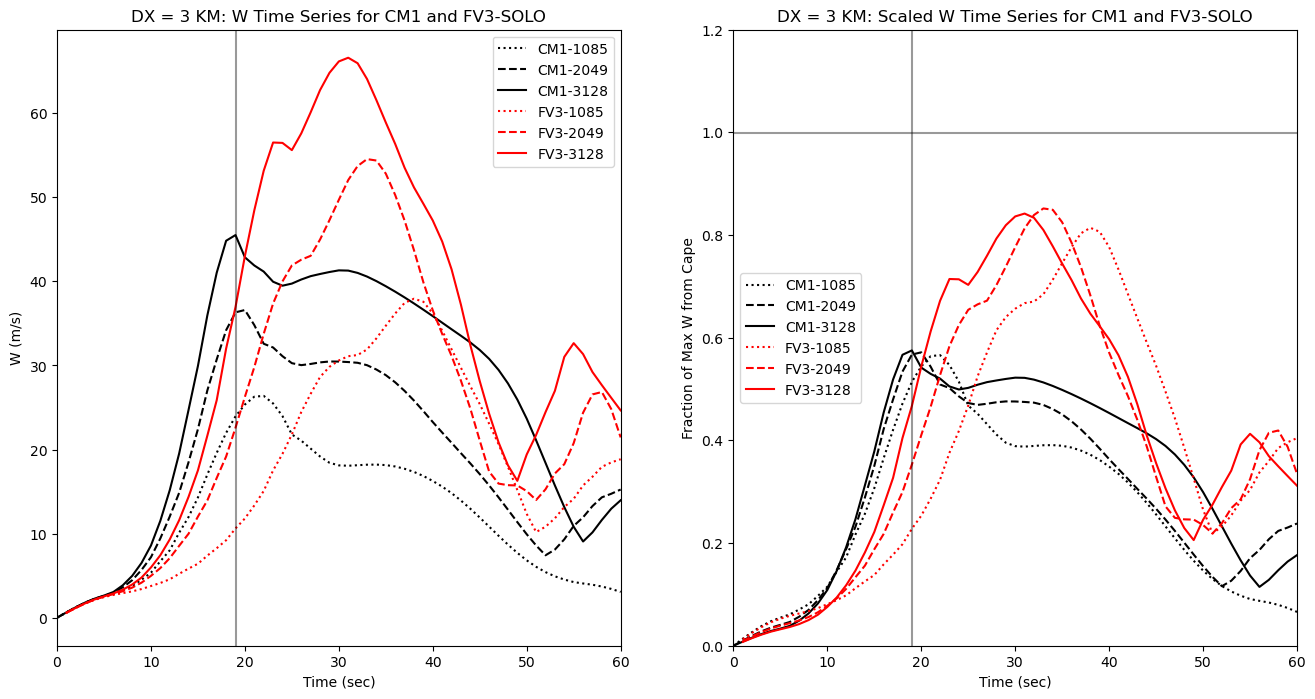

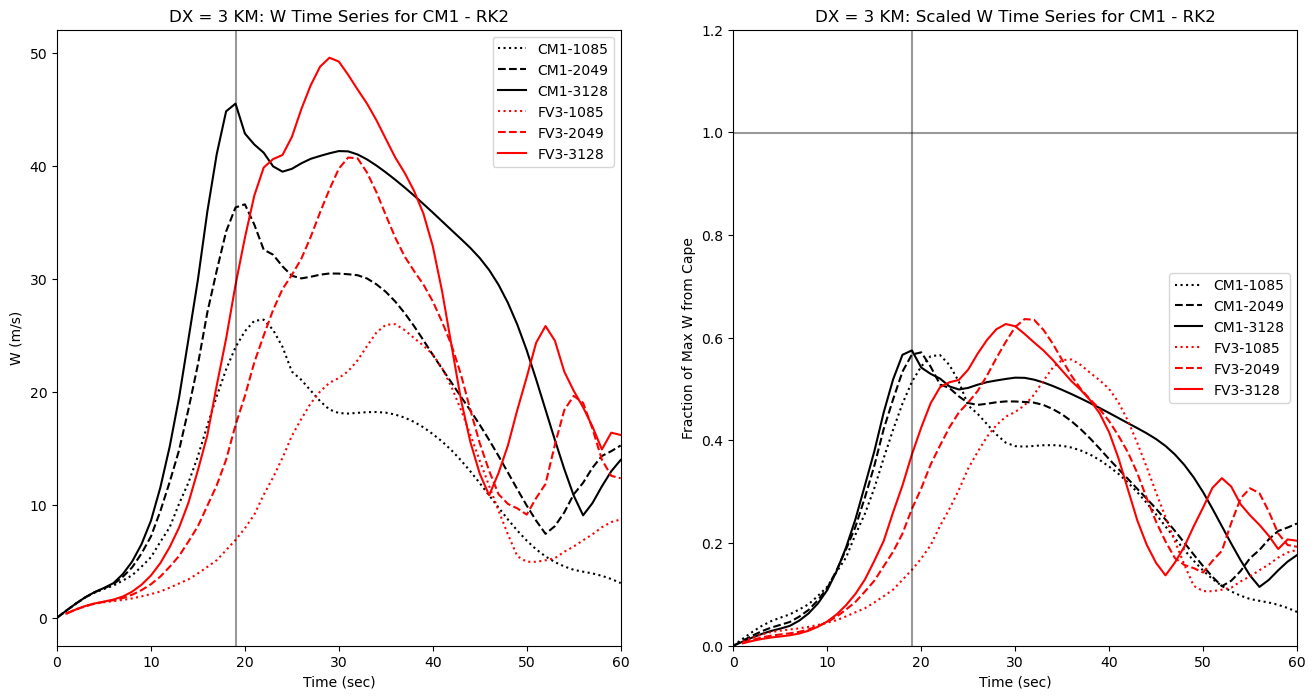

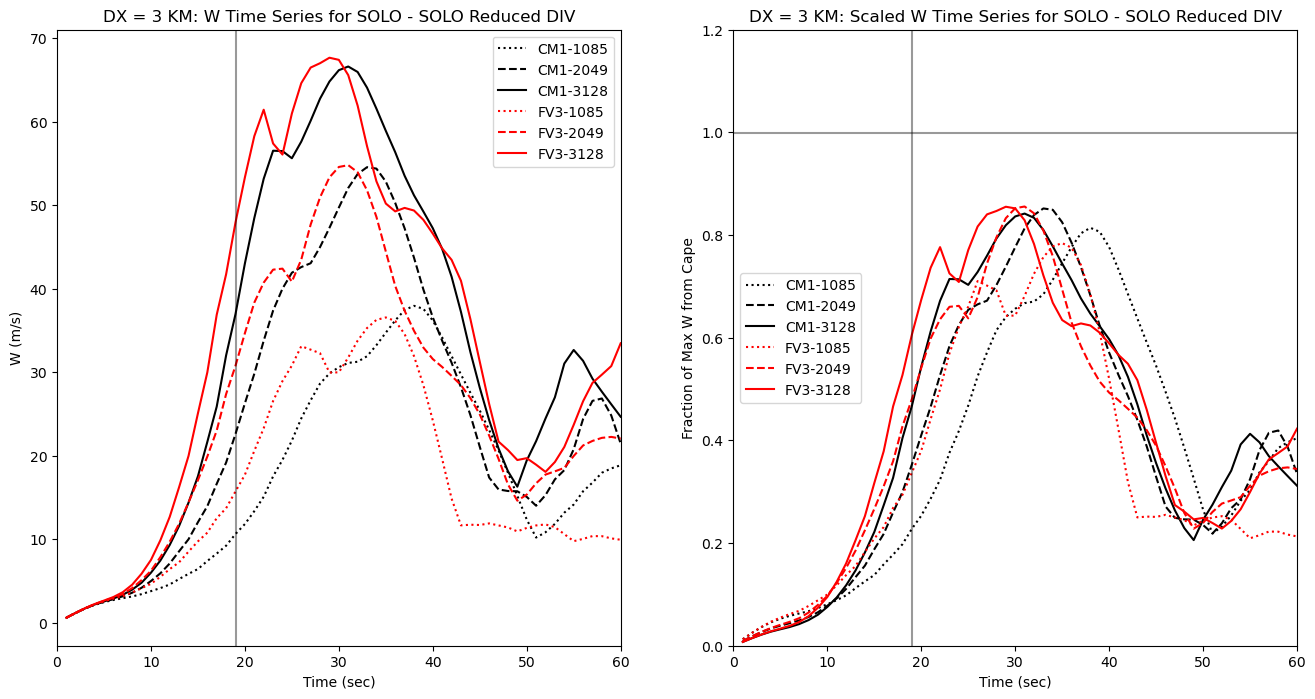

In [179]:

plot_wmax(c3, s3, res=3, subtitle='CM1 vs FV3-SOLO')

plot_wmax(c3, rk, res=3, subtitle='CM1 vs FV3-RK2')

plot_wmax(c3, d3, res=3, subtitle='CM1 vs SOLO Reduced DIV')

plot_wmax(c3, d3, res=3, subtitle='SOLO vs SOLO Reduced DIV')


# **1 km plots**

In [ ]:
euler = '/work/wicker/climate_runs/FV3_Solo/bubble/euler/1km'
rk    = '/work/wicker/climate_runs/FV3_Solo/bubble/rk/1km'
div   = '/work/wicker/climate_runs/FV3_Solo/bubble/div/1km'
cm1   = '/work/wicker/climate_runs/cm1r20.3/run/bubble/1km'

s1  = []
c1  = []
r1  = []
d1  = []

for key in plotlabels:  
    s1.append(read_solo_w(os.path.join(euler,key)))
    r1.append(read_solo_w(os.path.join(rk,key)))
    d1.append(read_solo_w(os.path.join(div,key)))
    c1.append(read_cm1_w(os.path.join(cm1,key)))

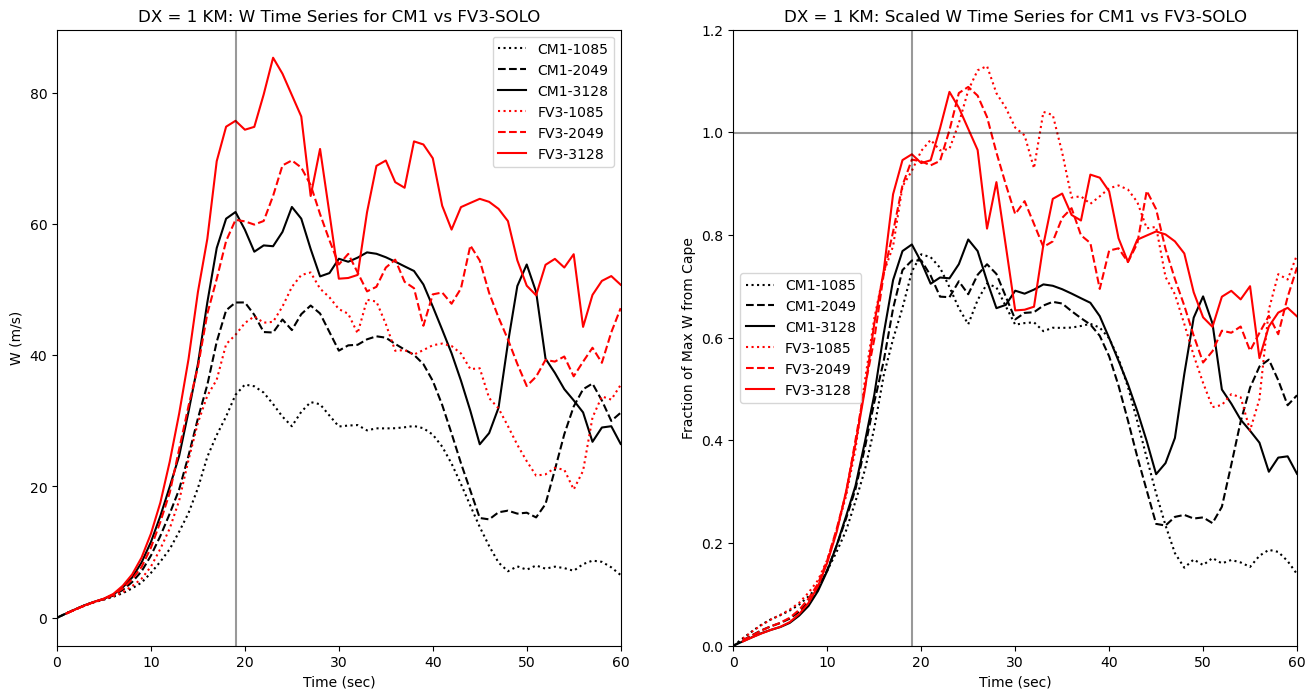

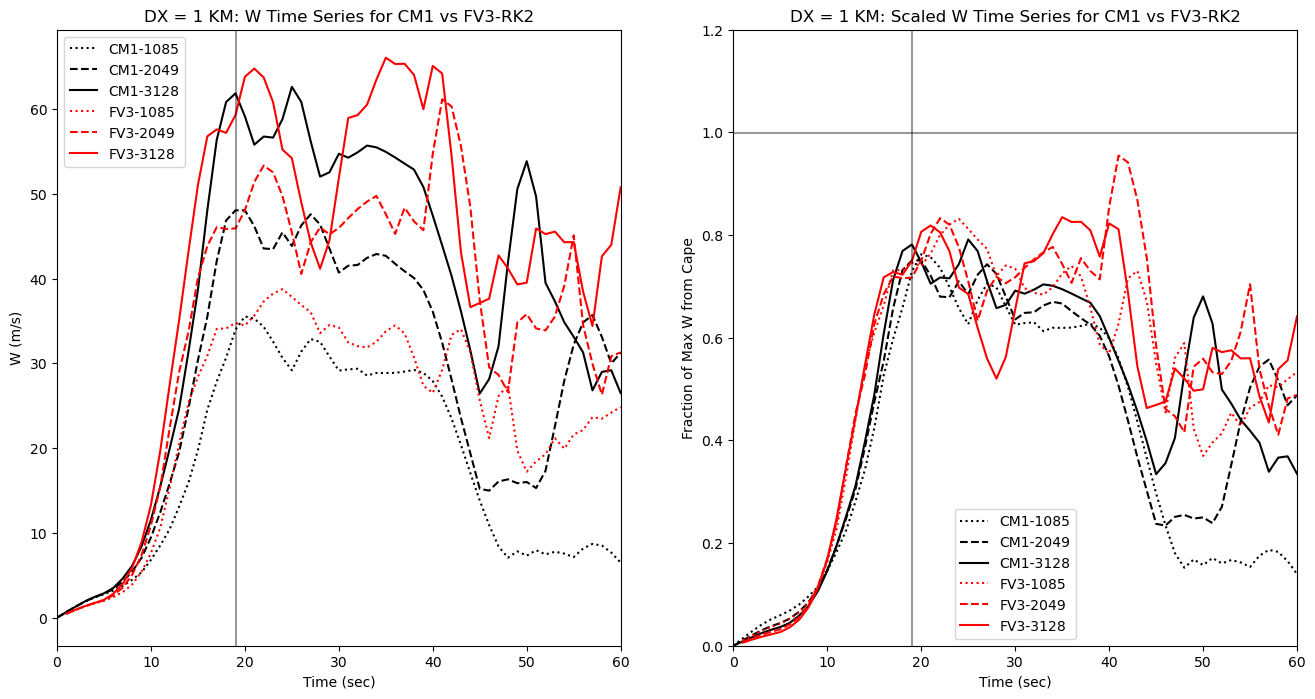

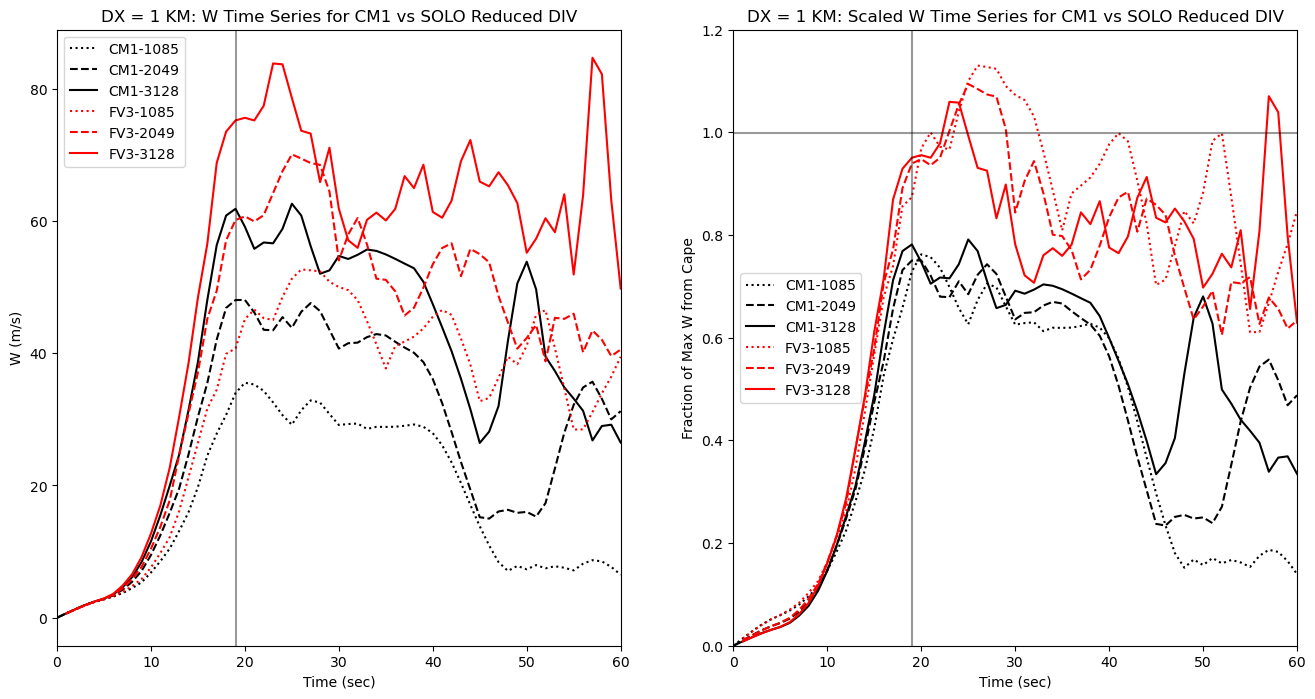

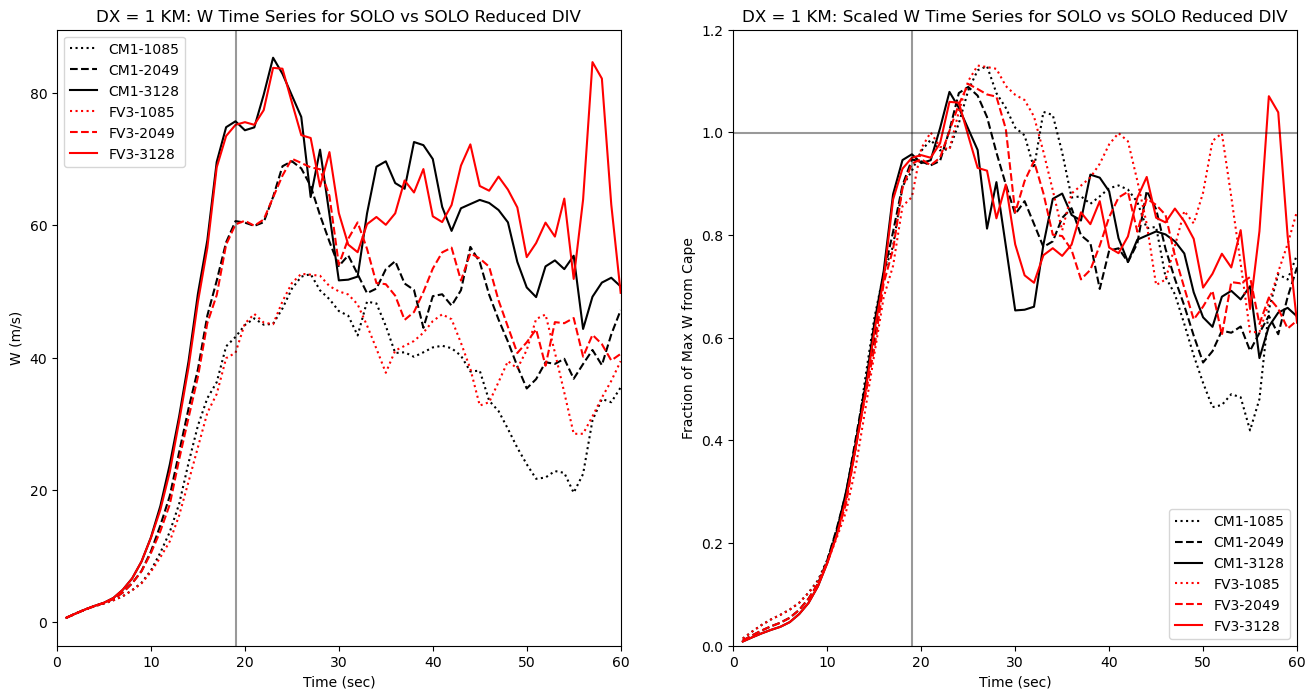

In [218]:
plot_wmax(c1, s1, res=1, subtitle='CM1 vs FV3-SOLO')

plot_wmax(c1, r1, res=1, subtitle='CM1 vs FV3-RK2')

plot_wmax(c1, d1, res=1, subtitle='CM1 vs SOLO Reduced DIV')

plot_wmax(s1, d1, res=1, subtitle='SOLO vs SOLO Reduced DIV')


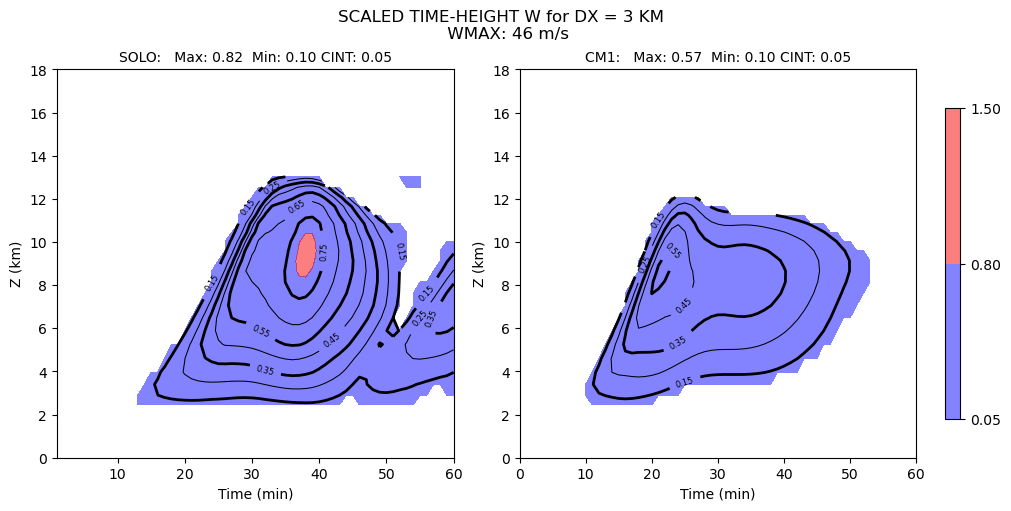

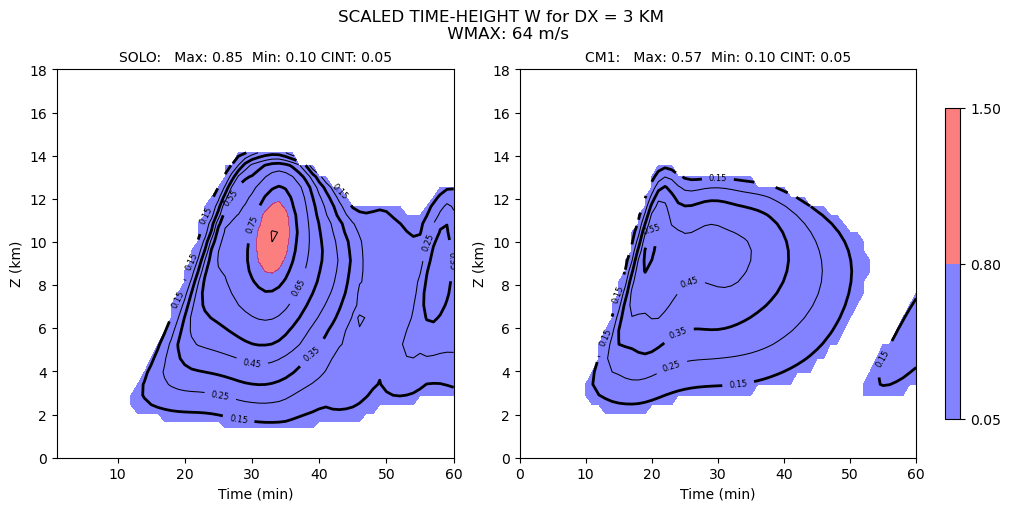

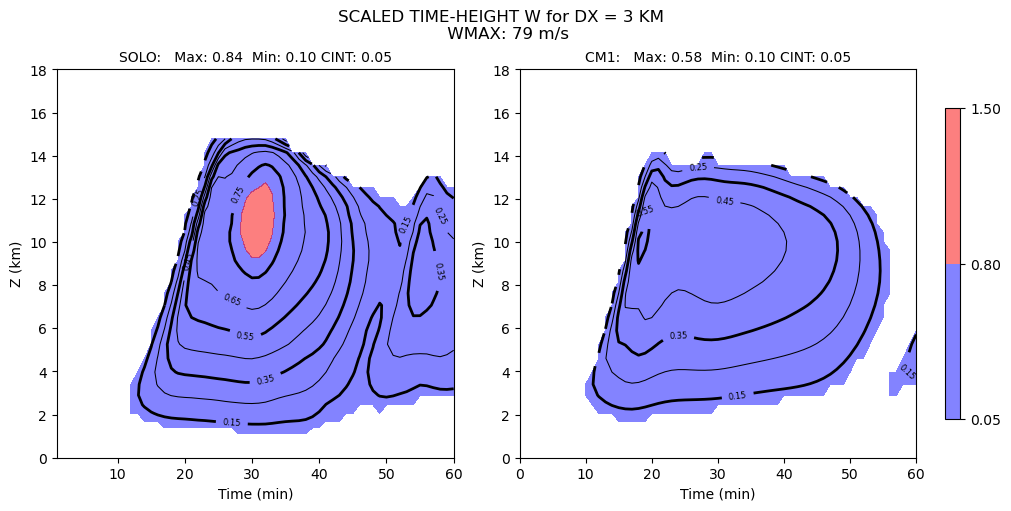

In [219]:
## 3 km plots

# for n, value in enumerate((1085, 2049, 3128)):

#     fields = []
#     fields.append(container(s3[n].w.max(axis=(2,3)).transpose(), s3[n].zc[0,:,0,0]/1000., s3[n].min))
#     fields.append(container(c3[n].w.max(axis=(2,3)).transpose(), s3[n].zc[0,:,0,0]/1000., c3[n].min))

#     plot_contour_row(fields, levels=wclevs, suptitle=f"DX = 3 KM:  CAPE: {value} J/kg", ptitle=['SOLO','CM1'], xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, 
#                  cmap=plt.cm.viridis_r, cint=2.5, ylim=(0,20.));

for n, value in enumerate((46,64,79)):

    fields = []
    fields.append(container(s3[n].w.max(axis=(2,3)).transpose()/value, s3[n].zc[0,:,0,0]/1000., s3[n].min))
    fields.append(container(c3[n].w.max(axis=(2,3)).transpose()/value, s3[n].zc[0,:,0,0]/1000., c3[n].min))

    plot_contour_row(fields, plot_type=2, clevels=scaled_wclevs, color_levels=[0.05, 0.8, 1.5], 
                     cmap=plt.cm.seismic,
                     suptitle=f"SCALED TIME-HEIGHT W for DX = 3 KM  \n WMAX: {value} m/s",
                     ptitle=['SOLO','CM1'], xlabel='Time (min)', 
                     ylabel='Z (km)', ylim=(0,18.), mask_less=0.1, fancy_lw=True);


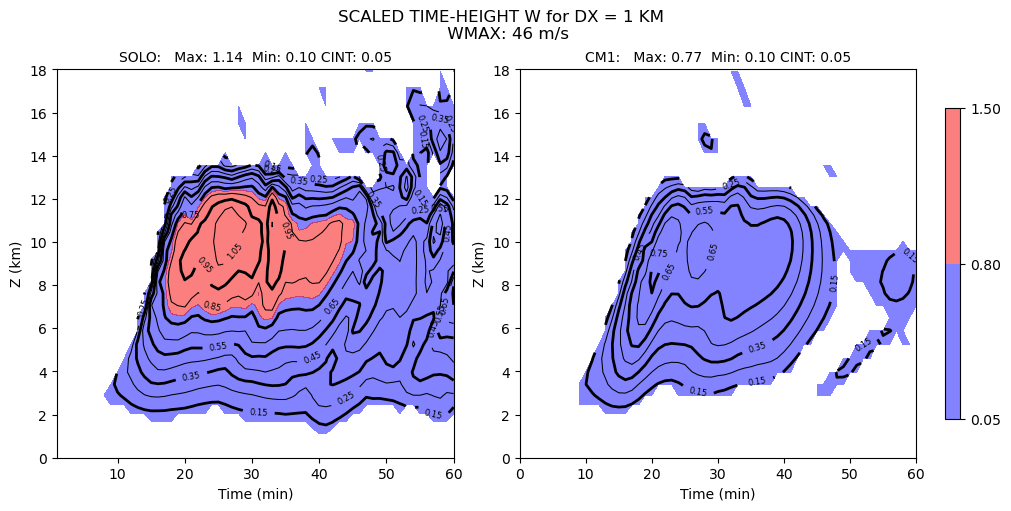

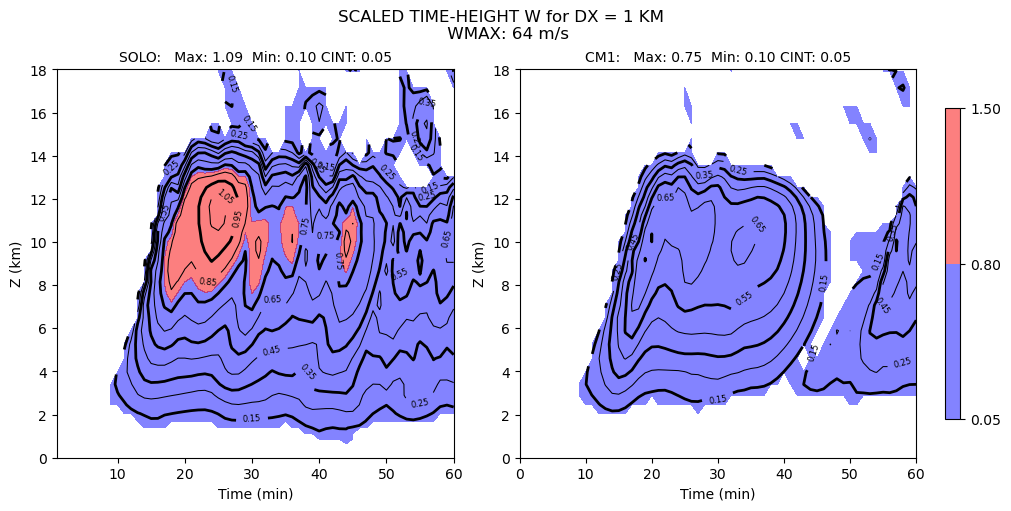

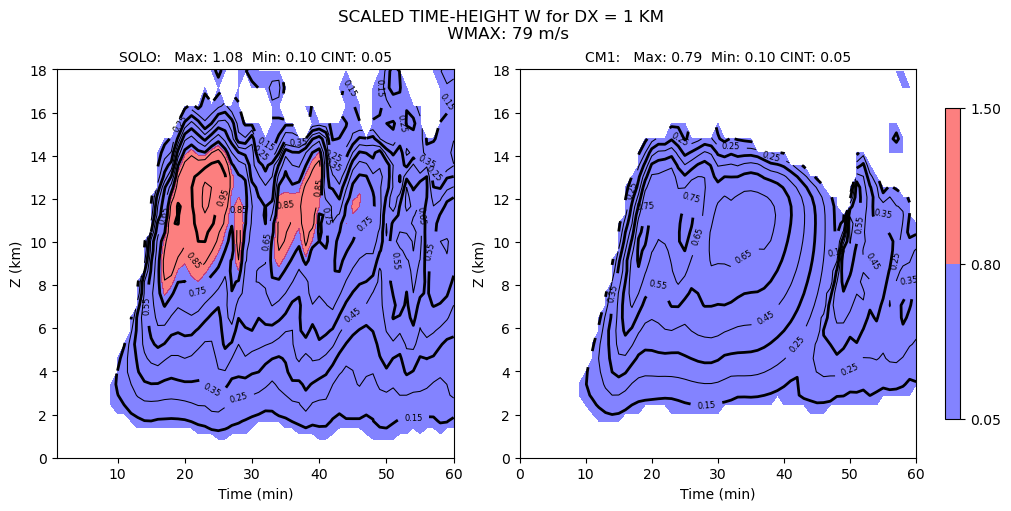

In [220]:
for n, value in enumerate((46,64,79)):

    fields = []
    # fields.append(container(s1[n].w.max(axis=(2,3)).transpose(), s1[n].zc[0,:,0,0]/1000., s1[n].min))
    # fields.append(container(c1[n].w.max(axis=(2,3)).transpose(), s1[n].zc[0,:,0,0]/1000., c1[n].min))

    fields.append(container(s1[n].w.max(axis=(2,3)).transpose()/value, s1[n].zc[0,:,0,0]/1000., s1[n].min))
    fields.append(container(c1[n].w.max(axis=(2,3)).transpose()/value, s1[n].zc[0,:,0,0]/1000., c1[n].min))


    plot_contour_row(fields, plot_type=2, clevels=scaled_wclevs, color_levels=[0.05, 0.8, 1.5], 
                     cmap=plt.cm.seismic,
                     suptitle=f"SCALED TIME-HEIGHT W for DX = 1 KM  \n WMAX: {value} m/s", 
                     ptitle=['SOLO','CM1'], xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, 
                     ylim=(0,18.), mask_less=0.1, fancy_lw=True);

In [142]:
def plot_w(cmodel, smodel, res=3, subtitle='CM1 and FV3-SOLO'):
    
    fig, ax = plt.subplots(1,2, figsize=(16,8))

    linestyles = [':','--','solid'] 
    
    capes = [1085.672061987397, 2049.503665750544, 3128.6993610705954]

    wscale = [46.59768368, 64.02349047, 79.10372129]

    for n, item in enumerate(cmodel):
        ax[0].plot(item.sec/60, item.w.max(axis=(1,2,3)), label=f"CM1-{int(capes[n])}", linestyle=linestyles[n], color='k')
        
    for n, item in enumerate(smodel):
        ax[0].plot(item.sec/60, item.w.max(axis=(1,2,3)), label=f"FV3-{int(capes[n])}", linestyle=linestyles[n], color='r')
    
    ax[0].set_xlim(0,60.)
    ax[0].set_title(f'DX = {res} KM: W Time Series for {subtitle}')
    ax[0].legend()
    ax[0].set_xlabel('Time (sec)')
    ax[0].set_ylabel('W (m/s)')
    ax[0].axvline(x=19., color='k', linestyle='solid', alpha=0.4)
    
    for n, item in enumerate(cmodel):
        if n == 0:
            linestyle = 'solid'
        else:
            linestyle = linestyle_tuple[n][1:][0]
            
        ax[1].plot(item.sec/60, item.w.max(axis=(1,2,3))/wscale[n], label=f"CM1-{int(capes[n])}", linestyle=linestyles[n], color='k')
        
    for n, item in enumerate(smodel):
        if n == 0:
            linestyle = 'solid'
        else:
            linestyle = linestyle_tuple[n][1:][0]
            
        ax[1].plot(item.sec/60, item.w.max(axis=(1,2,3))/wscale[n], label=f"FV3-{int(capes[n])}", linestyle=linestyles[n], color='r')
    
    ax[1].set_xlim(0,60)
    ax[1].set_ylim(0,1.2)
    ax[1].axhline(y=0.9995, color='k', linestyle='solid', alpha=0.4)
    ax[1].axvline(x=19., color='k', linestyle='solid', alpha=0.4)
    ax[1].set_title(f'DX = {res} KM: Scaled W Time Series for {subtitle}')
    ax[1].set_xlabel('Time (sec)')
    ax[1].legend()
    ax[1].set_ylabel('Fraction of Max W from Cape');

In [143]:
c3.*?

c3.__add__
c3.__class__
c3.__class_getitem__
c3.__contains__
c3.__delattr__
c3.__delitem__
c3.__dir__
c3.__doc__
c3.__eq__
c3.__format__
c3.__ge__
c3.__getattribute__
c3.__getitem__
c3.__gt__
c3.__hash__
c3.__iadd__
c3.__imul__
c3.__init__
c3.__init_subclass__
c3.__iter__
c3.__le__
c3.__len__
c3.__lt__
c3.__mul__
c3.__ne__
c3.__new__
c3.__reduce__
c3.__reduce_ex__
c3.__repr__
c3.__reversed__
c3.__rmul__
c3.__setattr__
c3.__setitem__
c3.__sizeof__
c3.__str__
c3.__subclasshook__
c3.append
c3.clear
c3.copy
c3.count
c3.extend
c3.index
c3.insert
c3.pop
c3.remove
c3.reverse
c3.sort

In [203]:
e3path = '/work/wicker/climate_runs/FV3_Solo/bubble/euler/3km'

e3 = []

for key in plotlabels:  
    e3.append(read_solo_w(os.path.join(e3path,key)))


------------------------------------------------------------------------------------------------------------------------
 Now reading... /work/wicker/climate_runs/FV3_Solo/bubble/euler/3km/QV12/atmos_hifreq.nc
 Completed reading: /work/wicker/climate_runs/FV3_Solo/bubble/euler/3km/QV12/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
 Now reading... /work/wicker/climate_runs/FV3_Solo/bubble/euler/3km/QV14/atmos_hifreq.nc
 Completed reading: /work/wicker/climate_runs/FV3_Solo/bubble/euler/3km/QV14/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
 Now reading... /work/wicker/climate_runs/FV3_Solo/bubble/euler/3km/QV16/atmos_hifreq.nc
 Completed reading: /work/wicker/climate_runs/FV3_Solo/bubble/euler/3km/QV16/atmos_hifreq.nc 



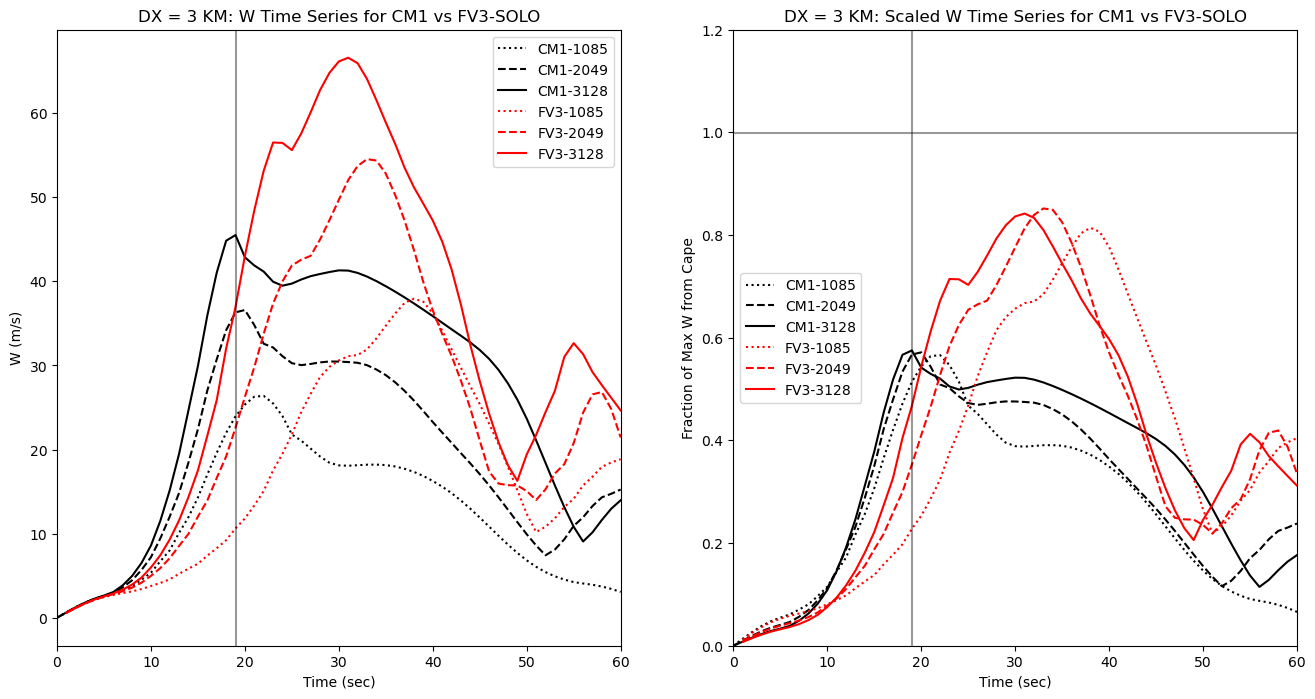

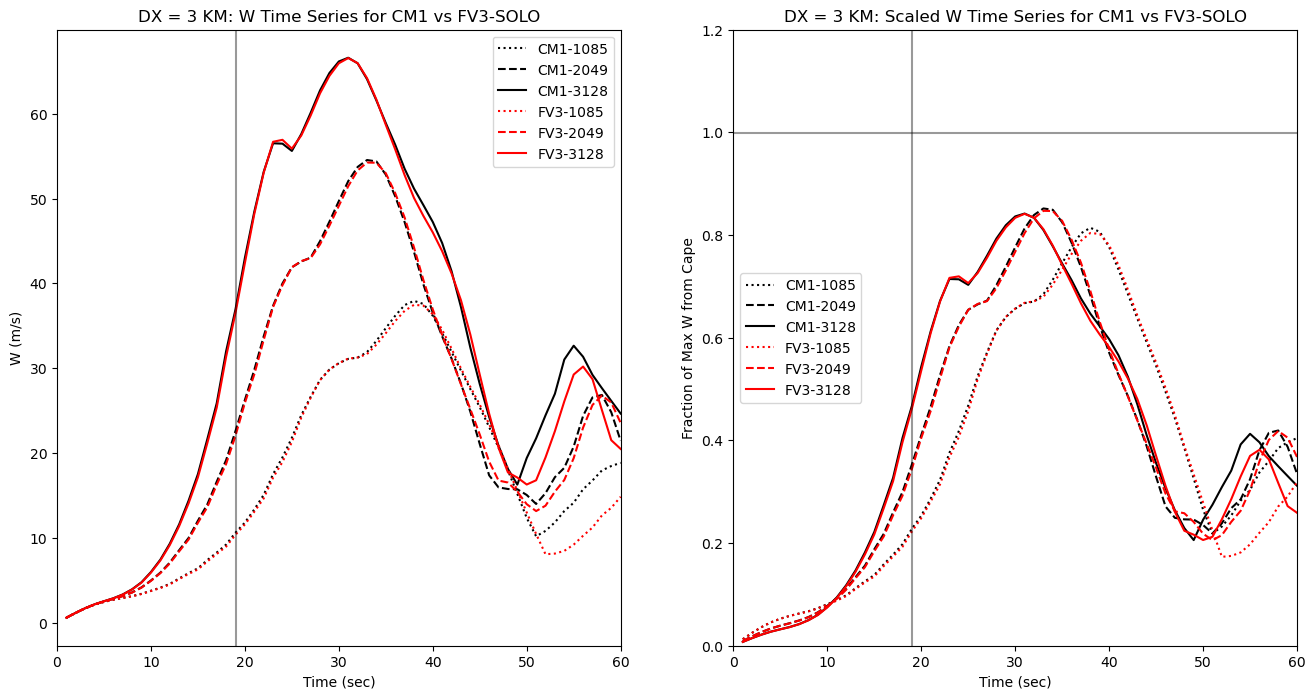

In [204]:
plot_wmax(c3, s3, res=3, subtitle='CM1 vs FV3-SOLO')
plot_wmax(s3, e3, res=3, subtitle='CM1 vs FV3-SOLO')